# 전이 학습

이미지 분류를 위한 CNN(Convolutional Neural Network)은 가장자리, 모서리 등과 같은 특징을 추출하는 여러 계층으로 구성됩니다. 그런 다음 최종 완전 연결 레이어를 사용하여 개체를 분류합니다. 다음과 같이 시각화 할 수 있습니다.

<table>
    <tr><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Convolutional Layer</td><td style='border: 1px solid black;'>Pooling Layer</td><td style='border: 1px solid black;'>Fully Connected Layer</td><td rowspan=2 style='border: 1px solid black;'>&#x21d2;</td></tr>
    <tr><td colspan=4 style='border: 1px solid black; text-align:center;'>Feature Extraction</td><td style='border: 1px solid black; text-align:center;'>Classification</td></tr>
</table>

*전이 학습*은 기존의 학습 된 모델을 가져 와서 특성 추출 계층을 재사용하여 최종 분류 계층을 사용자 지정 이미지로 훈련 된 완전 연결 계층으로 대체 할 수있는 기술 입니다. 이 기술을 사용하면 모델은 기본 모델 (액세스 권한이있는 것보다 더 큰 학습 데이터 세트를 기반으로 할 수 있음)에서 수행 된 특성 추출 학습을 통해 고유한 특정 객체 클래스 집합에 대한 분류 모델을 구축 할 수 있습니다.

이게 무슨 도움이 될까요? 예를 들어보면 여러분이 프로 테니스 선수와 완전히 초보자를 데리고, 그들에게 라켓볼을 어떻게 하는지 가르치려고 노력한다고 가정해봅시다. 라켓볼에 관련된 기본 기술 중 많은 것들이 이미 학습되어 있기 때문에 프로 테니스 선수가 훈련하기 더 쉬울 것이라고 추측하는 것이 타당 합니다. 마찬가지로, 사전 교육된 CNN 모델은 가장자리 및 모서리와 같은 공통 객체의 특징을 식별하는 방법을 이미 배웠기 때문에 특정 객체 세트를 분류하기 위해 훈련하기가 더 쉬울 수 있습니다. 기본적으로, 사전 교육된 모델은 교육할 데이터가 제한된 경우에도 효과적인 분류기를 생성할 수 있는 좋은 방법이 될 수 있습니다.

이 노트에서는 Pytorch를 사용하여 분류 모델에 대한 이전 학습을 구현하는 방법을 알아보겠습니다.

## 라이브러리 설치 및 가져 오기

사용할 PyTorch 라이브러리를 설치하고 가져옵니다.

In [1]:
# !pip install torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

# Other libraries we'll use
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.7.1+cpu


## 기본 모델 준비

전이 학습을 사용하려면 훈련 된 피쳐 추출 레이어를 사용할 수 있는 기본 모델이 필요합니다. ***resnet*** 모델은 1000개의 객체 클래스의 많은 이미지를 포함하는 방대한 데이터 세트를 사용하여 사전 학습된 CNN 기반 이미지 분류기이므로 다운로드 하여 해당 레이어를 살펴보겠습니다. 

In [3]:
# Load the model (download if not already present)
model = torchvision.models.resnet34(pretrained=True)

print(model)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/brfuser/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 이미지 데이터 준비

사전 훈련 된 모델에는 이미지 데이터에서 피쳐 추출 프로세스를 시작하는 convolution 레이어에서 시작하여 추출된 피쳐를 1000개의 클래스 레이블에 매핑하는 완전 연결 선형 레이어으로 끝나는 레이어 등, 여러 레이어들이 있습니다.

특성 추출이 자체 이미지와 함께 작동하려면 예측 계층을 훈련하는데 사용하는 이미지 데이터에 피쳐 추출 레이어를 훈련하는 데 원래 사용 된 이미지와 동일한 수의 피쳐(픽셀 값)가 있는지 확인해야합니다. 모델은 크기를 명시적으로 제공하지 않지만 첫 번째 컨벌루션 레이어은 2x2의 stride을 가진 7x7 커널에 의해 적용되고 64 개의 특성 값이 생성되므로 원래 크기는 64x(7&div;2), 즉 224 여야합니다.

PyTorch에는 데이터 로드 및 변환 기능이 포함되어 있습니다. 이를 사용하여 학습 데이터용 반복 로더(iterator loader)를 만들고 테스트 데이터용 두 번째 반복 로더(iterator loader)(학습된 모델의 유효성 검사에 사용)를 만듭니다. Loader는 원본 resnet CNN 모델을 훈련하는 데 사용된 형식과 일치하도록 이미지 데이터를 변환하고, 이미지 데이터를 *Tensor* (PyTorch에서 사용되는 핵심 데이터 구조)로 변환하고 정규화합니다.

다음 셀을 실행하여 데이터 로더(DataLodaer)를 정의하고 이미지의 클래스를 나열하십시오.

In [4]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    
    # Resize to 256 x 256, then center-crop to 224x224 (to match the resnet image size)
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    # Split into training (70%) and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 30-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=30,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 30-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=30,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


# Now load the images from the shapes folder
import os  
data_path = 'data/shapes/'

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print('class names:', classes)

class names: ['circle', 'square', 'triangle']


## 예측 레이어 만들기

최종 **fc**(fully connected) 선형 레이어를 포함하여 전체 *resnet* 모델을 다운로드 했습니다. 이 fc 선형 계층은 512 개의 입력(추출 된 피쳐)을 사용하고 1000 개의 출력(원래 훈련 이미지 클래스를 기반으로 한 클래스 예측)을 생성합니다. 이 레이어를 동일한 수의 입력을 사용하는 레이어로 교체 해야하지만(추출 된 동일한 수의 특징을 사용할 수 있음) 각 이미지 클래스에 대한 예측을 생성합니다.

또한 훈련 가중치를 유지하기 위해 피쳐 추출 레이어를 고정해야합니다. 그런 다음 이미지를 사용하여 모델을 학습할 때 최종 예측 레이어만 새로운 가중치와 편향값을 학습합니다. 피쳐 추출을 위해 사전 학습된 가중치는 동일하게 유지됩니다.

In [5]:
# Set the existing feature extraction layers to read-only
for param in model.parameters():
    param.requires_grad = False

# Replace the prediction layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

# Now print the full model, which will include the feature extraction layers of the base model and our prediction layer
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 모델 학습

CNN 레이어가 정의되었으므로 이미지 데이터를 사용하여 훈련 할 준비가되었습니다. 기본 resnet 모델의 특성 추출 레이어에 사용 된 가중치는 학습에 의해 변경되지 않으며 클래스에 매핑하는 최종 선형 계층(fc layer)만 훈련됩니다.

In [6]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)
        
        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics for every 10 batches so we see some progress
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model = model.to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 3 epochs (in a real scenario, you'd likely use many more)
epochs = 3
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
Training set [0/840 (0%)] Loss: 0.986712
Training set [300/840 (36%)] Loss: 0.709709
Training set [600/840 (71%)] Loss: 0.331256
Training set: Average loss: 0.509090
Validation set: Average loss: 0.290946, Accuracy: 355/360 (99%)

Epoch: 2
Training set [0/840 (0%)] Loss: 0.207845
Training set [300/840 (36%)] Loss: 0.383816
Training set [600/840 (71%)] Loss: 0.141192
Training set: Average loss: 0.174805
Validation set: Average loss: 0.105390, Accuracy: 360/360 (100%)

Epoch: 3
Training set [0/840 (0%)] Loss: 0.085142
Training set [300/840 (36%)] Loss: 0.253075
Training set [600/840 (71%)] Loss: 0.092507
Training set: Average loss: 0.103070
Validation set: Average loss: 0.070139, Accuracy: 360/360 (100%)



## Loss(손실) 확인하기

각 epoch에 대한 평균 훈련 및 검증 손실을 추적합니다. 그 이유는 모델이 학습됨에 따라 손실이 감소했는지 확인하고 *과적합* (검증 데이터의 손실이 평준화 되거나 증가하기 시작한 후에도 학습 데이터의 손실이 계속적으로 감소함을 나타냄)을 감지하기 위해 이를 시각화 하여 살펴봅니다.

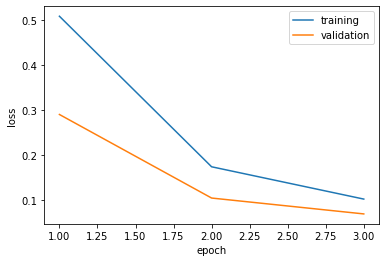

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## 모델 성능 평가

테스트 데이터를 기반으로 최종 정확도를 볼 수 있지만 일반적으로 성능 메트릭을 좀 더 자세히 살펴 보는게 좋습니다. 모델이 각 클래스를 얼마나 잘 예측하는지 확인하기 위해 confusion matrix(혼동 행렬)을 시각화 해 보겠습니다.

Getting predictions from test set...


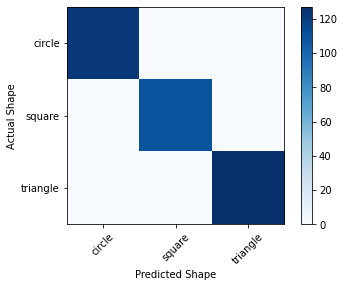

In [8]:
#Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Set the model to evaluate mode
model.eval()

# Get predictions for the test data and convert to numpy arrays for use with SciKit-Learn
print("Getting predictions from test set...")
truelabels = []
predictions = []
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("Actual Shape")
plt.show()

## 훈련된 모델 사용

이제 모델을 학습 했으므로 이미지 클래스를 예측하는 데 사용할 수 있습니다. 

triangle


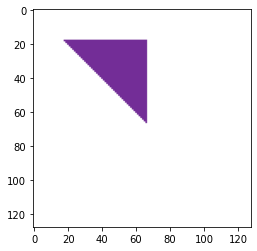

In [9]:
# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'circle':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'triangle':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    else: # square
        draw.rectangle([(xy1,xy1), (xy2,xy2)], fill=col)
    del draw
    
    return img
    
# Function to predict the class of an image
def predict_image(classifier, image):
    import numpy
    
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all inputs as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input_features = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input_features)
    index = output.data.numpy().argmax()
    return index


# Now let's try it with a new image
from random import randint
from PIL import Image
import os, shutil

# Create a random test image
shape = classes[randint(0, len(classes)-1)]
img = create_image ((128,128), shape)

# Display the image
plt.imshow(img)


index = predict_image(model, img)
print(classes[index])

## Learn more

* [PyTorch Documentation](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)